In [6]:
# imports
from pyedflib import highlevel
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Read edf files


In [70]:
from pyedflib import highlevel

signals, signal_headers, header = highlevel.read_edf('/home/lee/code/mariaaraujovitoria/SeizurePredict/raw_data/eeg5.edf')


In [71]:
# check sample rate
print(f"Sample rate (data points acquired per second): {signal_headers[0]['sample_frequency']}") # prints 256

# check shape of data: electrodes x datapoints
print(f"Data shape per participant 'number of electrodes x datapoints (256 points per second)': {signals.shape}")

# check info for electrode 
print(f"Electrode info: {signal_headers[6]}")

# headers for each electrode
#print(signal_headers) # it's huge make sure you write it in a different cell

Sample rate (data points acquired per second): 256.0
Data shape per participant 'number of electrodes x datapoints (256 points per second)': (21, 983296)
Electrode info: {'label': 'EEG F8-Ref', 'dimension': 'uV', 'sample_rate': 256.0, 'sample_frequency': 256.0, 'physical_max': 4999.847, 'physical_min': -4999.84, 'digital_max': 32767, 'digital_min': -32767, 'prefilter': 'HP:0.000 Hz LP:0.0 Hz N:0.0', 'transducer': 'Unknown'}


In [72]:
# check electrodes (do we want/need them all?) 
names_ele = [signal_headers[iele]['label'] for iele in range(signals.shape[0])]

#for iele in range(signals.shape[0]):
#    names_ele.append(signal_headers[iele]['label'])
    
names_ele

['EEG Fp1-Ref',
 'EEG Fp2-Ref',
 'EEG F7-Ref',
 'EEG F3-Ref',
 'EEG Fz-Ref',
 'EEG F4-Ref',
 'EEG F8-Ref',
 'EEG T3-Ref',
 'EEG C3-Ref',
 'EEG Cz-Ref',
 'EEG C4-Ref',
 'EEG T4-Ref',
 'EEG T5-Ref',
 'EEG P3-Ref',
 'EEG Pz-Ref',
 'EEG P4-Ref',
 'EEG T6-Ref',
 'EEG O1-Ref',
 'EEG O2-Ref',
 'ECG EKG',
 'Resp Effort']

## Read annotation files

In [73]:
import scipy.io

# load annotation file
annt = scipy.io.loadmat('/home/lee/code/mariaaraujovitoria/SeizurePredict/raw_data/annotations_2017.mat')

In [74]:
# check keys
print(f"Keys at annotation file: {annt.keys()}")

# create variable with annotation data for all subjects
annt_data= annt["annotat_new"]

# annt_data.shape
print(f"Annotation file shape 'array x number of participants': {annt_data.shape}")

# annotation for subject eeg2
annt_sub0= annt_data[0][1]

# check data shape
print(f"Annotation file shape for subject zero 'number of annotations (3 neurologist) x per second': {annt_sub0.shape}")



Keys at annotation file: dict_keys(['__header__', '__version__', '__globals__', 'annotat_new'])
Annotation file shape 'array x number of participants': (1, 79)
Annotation file shape for subject zero 'number of annotations (3 neurologist) x per second': (3, 3761)


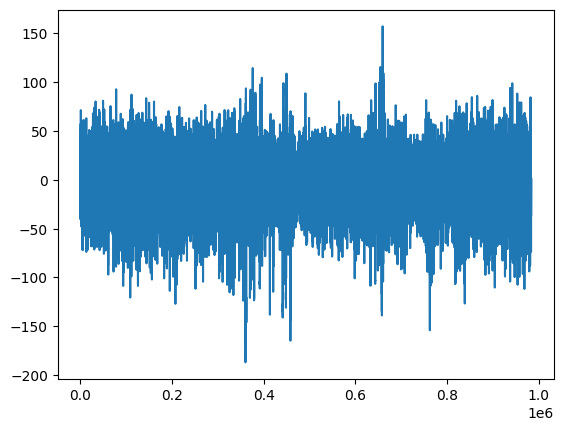

In [75]:
import matplotlib.pyplot as plt

plt.plot(signals[13,:])

## Read clinical info


In [76]:
import pandas as pd

cl_info = pd.read_csv('/home/lee/code/mariaaraujovitoria/SeizurePredict/raw_data/clinical_information.csv')

cl_info.head()


,ID,EEG file,Gender,BW (g),GA (weeks),EEG to PMA (weeks),Diagnosis,Neuroimaging Findings,PNA of Imaging (days),Number of Reviewers Annotating Seizure,Primary Localisation,Other
0,1,eeg1,f,less than 2500g,37 to 38,37 to 38,mild/moderate asphyxia,widespread ischemic changes,0 to 4,3,both hemispheres; alternating,NaN
1,2,eeg2,m,less than 2500g,35 to 36,37 to 38,prematurity,ultrasound normal,0 to 4,1,NaN,NaN
2,3,eeg3,m,NaN,40 to 41,41 to 42,NaN,NaN,NaN,0,NaN,NaN
3,4,eeg4,m,3000 to 3500g,39 to 40,39 to 40,mild/moderate asphyxia,bilateral watershed area infarction,4 to 7,3,right centro-parietal,NaN
4,5,eeg5,f,2500 to 3000g,39 to 40,39 to 40,asphyxia (undefined grade); neonatal convulsions,haemorrhage in left lateral ventricle; subarac...,0 to 4,3,left hemisphere,NaN


## Check version of pyedflib

In [77]:
import pyedflib

In [78]:
pyedflib.__version__

'0.1.30'

## Preprocessing steps


- load data
- notch filter (remove powerline - check if it is 50 or 60 Hz)
- linear detrend
- re-referencing (CAR for ex)
- remove artifatcs (how? muscle, eye blink,... - ICA commonly used)
- inspect data per subject - general package to plot or we can try mne specific for eeg
- label data (discuss together)

(...)


- do fourrier transform (removes time domain) or hilbert transform (conserves time domain) to do spectral analysis


Things to think about:
1. how to deal with 3 annotations
2. how to label data
3. 10s rule for seizure


## Preprocessing

### hp filter

In [43]:
from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz

# Sample frequency (Hz)
samp_freq = signal_headers[0]["sample_rate"]  

# Frequency to be high pass (Hz)
hp_freq = 0.1

# Design hp filter
sos = butter(N = 3, Wn = hp_freq, btype="highpass",fs=samp_freq, output="sos")

# Apply hp filter to signals
filter_hp = sosfiltfilt(sos, signals)

# Compute the frequency response of a digital filter.
w, h = sosfreqz(sos, fs = samp_freq)
# apply 
t = np.linspace(0.0, 1, 256)

Text(0, 0.5, 'mV')

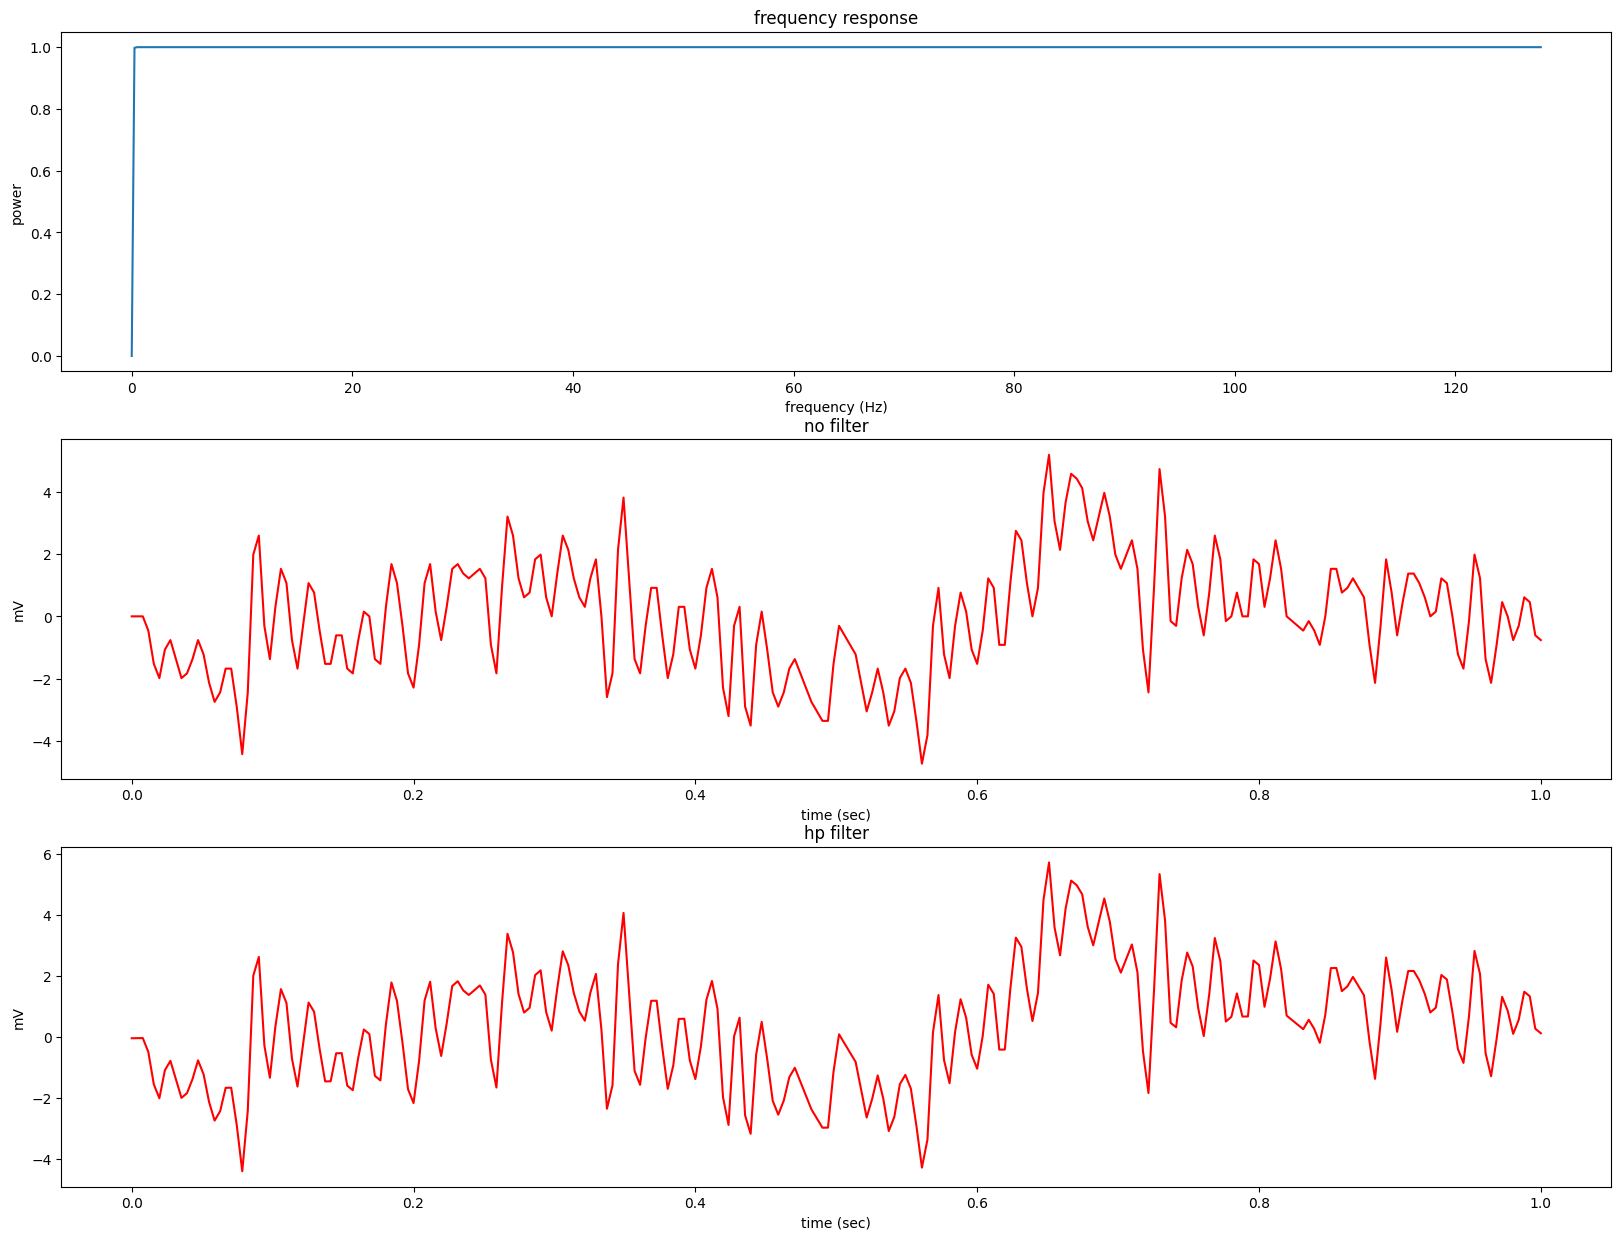

In [44]:
# plot filter
fig1, axis = plt.subplots(3,1,figsize = (20,15))
axis[0].plot(w, (abs(h)))
# axis[0].plot(w, (abs(h)))
axis[0].set_title("frequency response")
axis[0].set_xlabel("frequency (Hz)")
axis[0].set_ylabel("power")

axis[1].plot(t, signals[0][0:256], color = 'r')
axis[1].set_title("no filter")
axis[1].set_xlabel("time (sec)")
axis[1].set_ylabel("mV")


axis[2].plot(t, filter_hp[0][0:256], color = 'r')
axis[2].set_title("hp filter")
axis[2].set_xlabel("time (sec)")
axis[2].set_ylabel("mV")

### notch filter

In [45]:
from scipy.signal import freqz, iirnotch, filtfilt

# Sample frequency (Hz)
samp_freq = signal_headers[0]["sample_rate"]  

# Frequency to be removed from signal (Hz)
notch_freq = 50.0 

# Quality factor
quality_factor = 30.0

# normalized
w0 = notch_freq/(samp_freq/2)

# Design notch filter
b_notch, a_notch = iirnotch(w0, quality_factor)

# Apply notch filter to signals
filter_notch = filtfilt(b_notch, a_notch, filter_hp, axis = -1)

# Compute the frequency response of a digital filter.
w, h = freqz(b_notch, a_notch, fs = samp_freq)
# apply 
t = np.linspace(0.0, 1, 256)

Text(0, 0.5, 'mV')

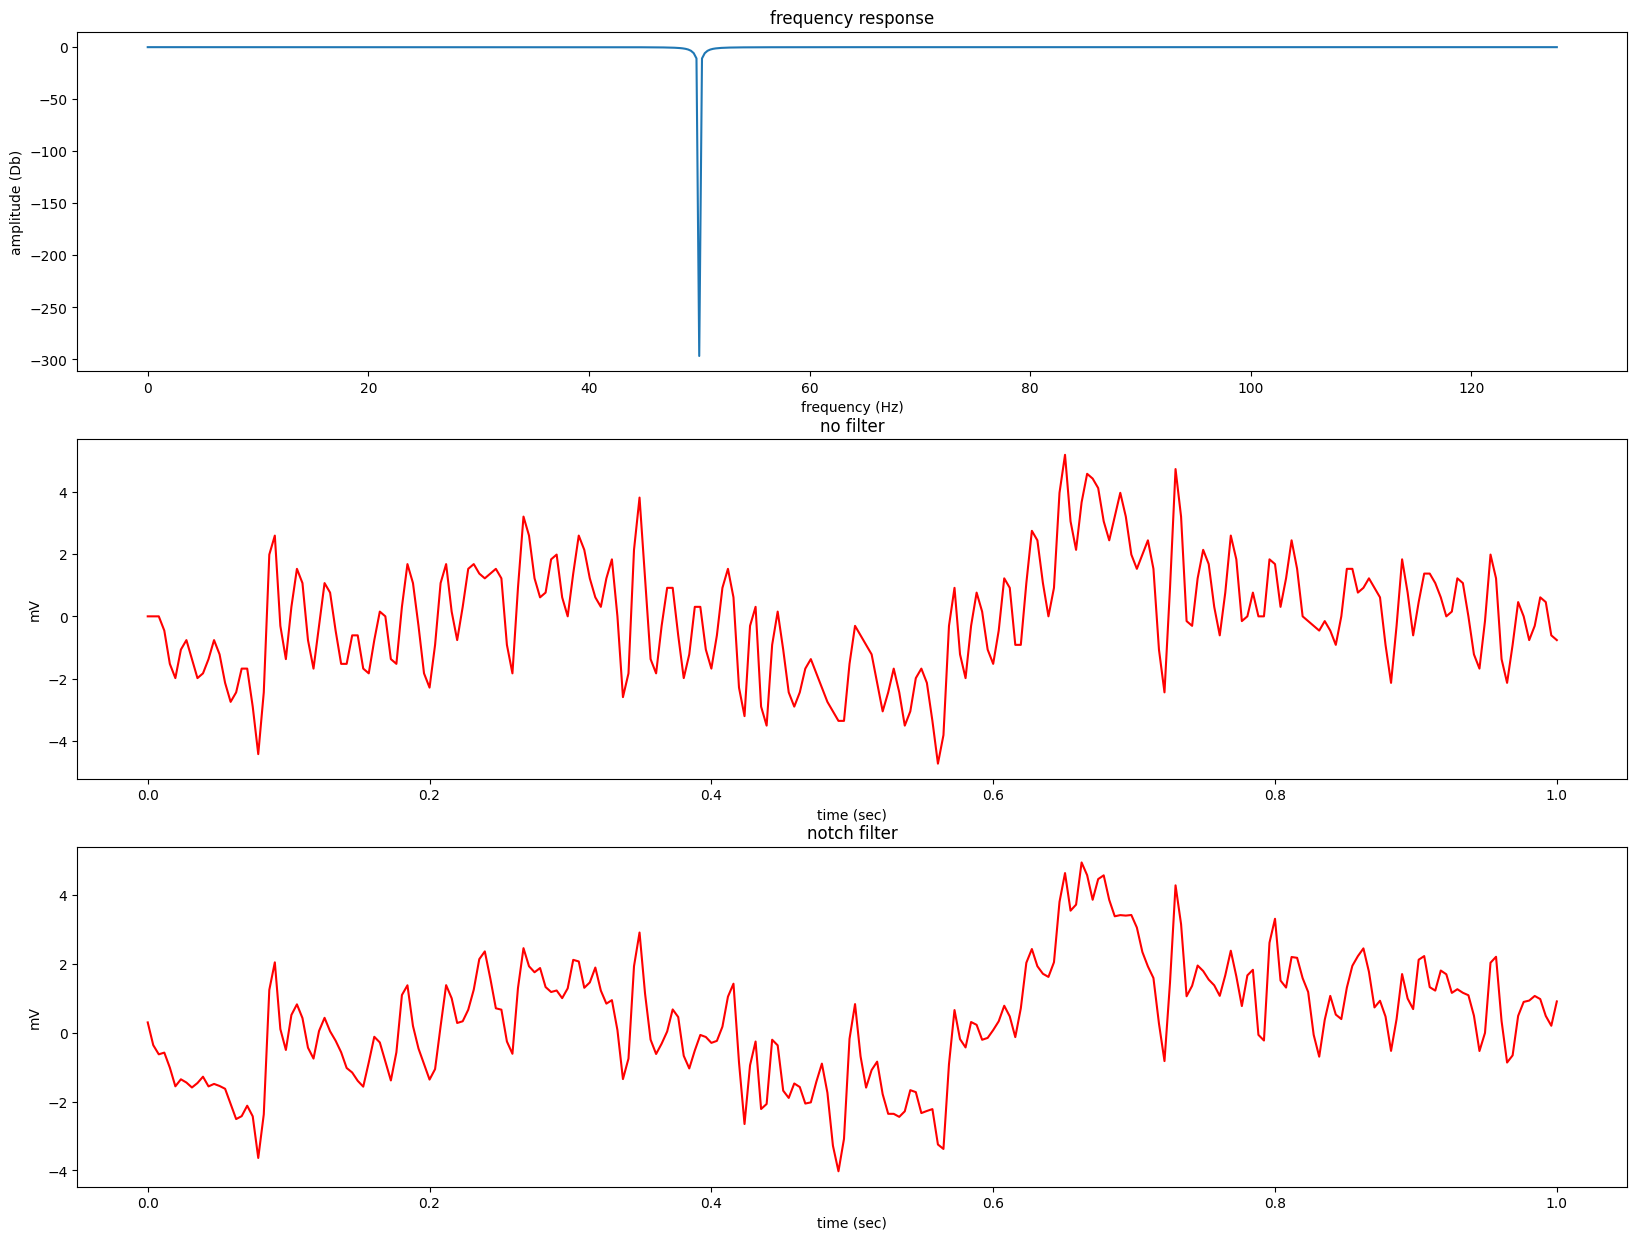

In [46]:
# plot filter
fig1, axis = plt.subplots(3,1,figsize = (20,15))
axis[0].plot(w, 20*np.log10(abs(h)))
# axis[0].plot(w, (abs(h)))
axis[0].set_title("frequency response")
axis[0].set_xlabel("frequency (Hz)")
axis[0].set_ylabel("amplitude (Db)")

axis[1].plot(t, signals[0][0:256], color = 'r')
axis[1].set_title("no filter")
axis[1].set_xlabel("time (sec)")
axis[1].set_ylabel("mV")


axis[2].plot(t, filter_notch[0][0:256], color = 'r')
axis[2].set_title("notch filter")
axis[2].set_xlabel("time (sec)")
axis[2].set_ylabel("mV")

### plot hp filter fourier

In [49]:
# just to check that the filter is working as expected

In [50]:
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
N = len(signals[0])
xf = fftfreq(N, 1 / samp_freq)

Text(0, 0.5, 'amp')

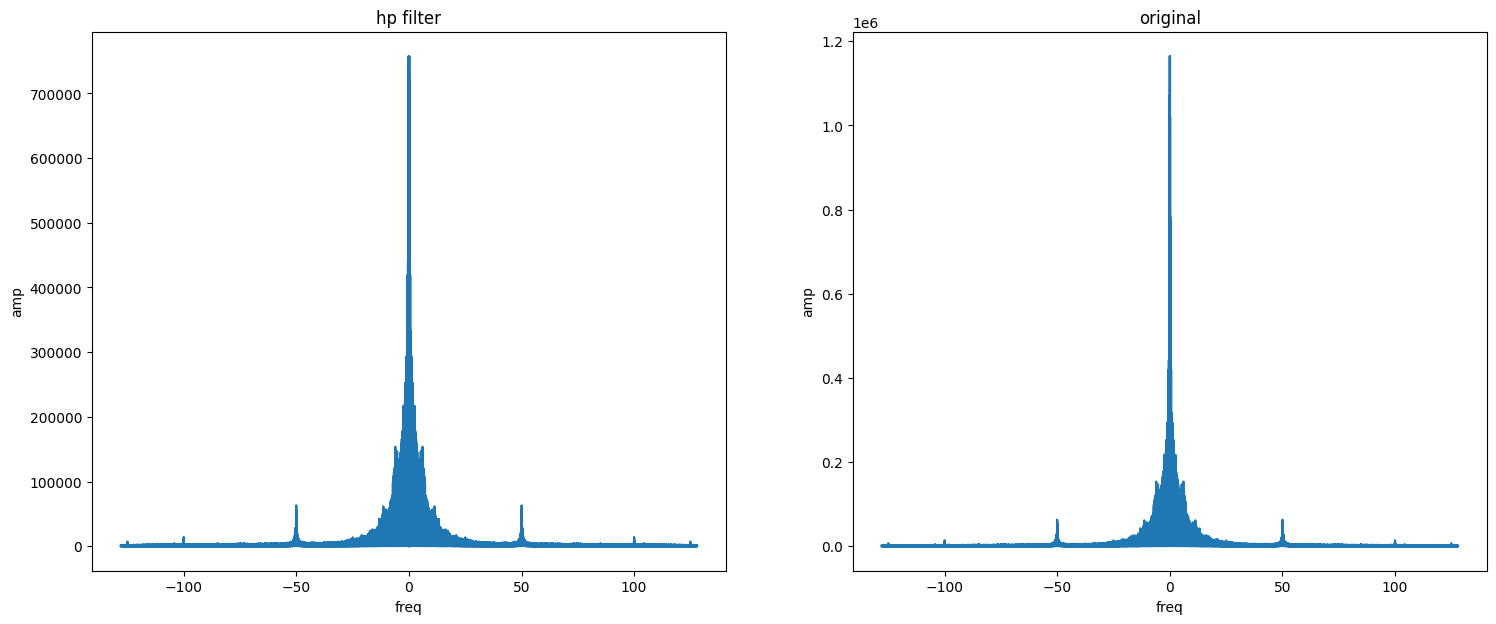

In [51]:
fig, ax = plt.subplots(1,2, figsize = (18,7))
ax[0].plot(xf, abs(fft(filter_hp[0])))
ax[0].set_title("hp filter")
ax[0].set_xlabel("freq")
ax[0].set_ylabel("amp")
ax[1].plot(xf, abs(fft(signals[0])))
ax[1].set_title("original")
ax[1].set_xlabel("freq")
ax[1].set_ylabel("amp")

### plot notch filter fourier

In [23]:
# just to check that the filter is working as expected

In [52]:
# fourier transform
y = fft(filter_notch[0])
amp = np.abs(y)

Text(0, 0.5, 'amp')

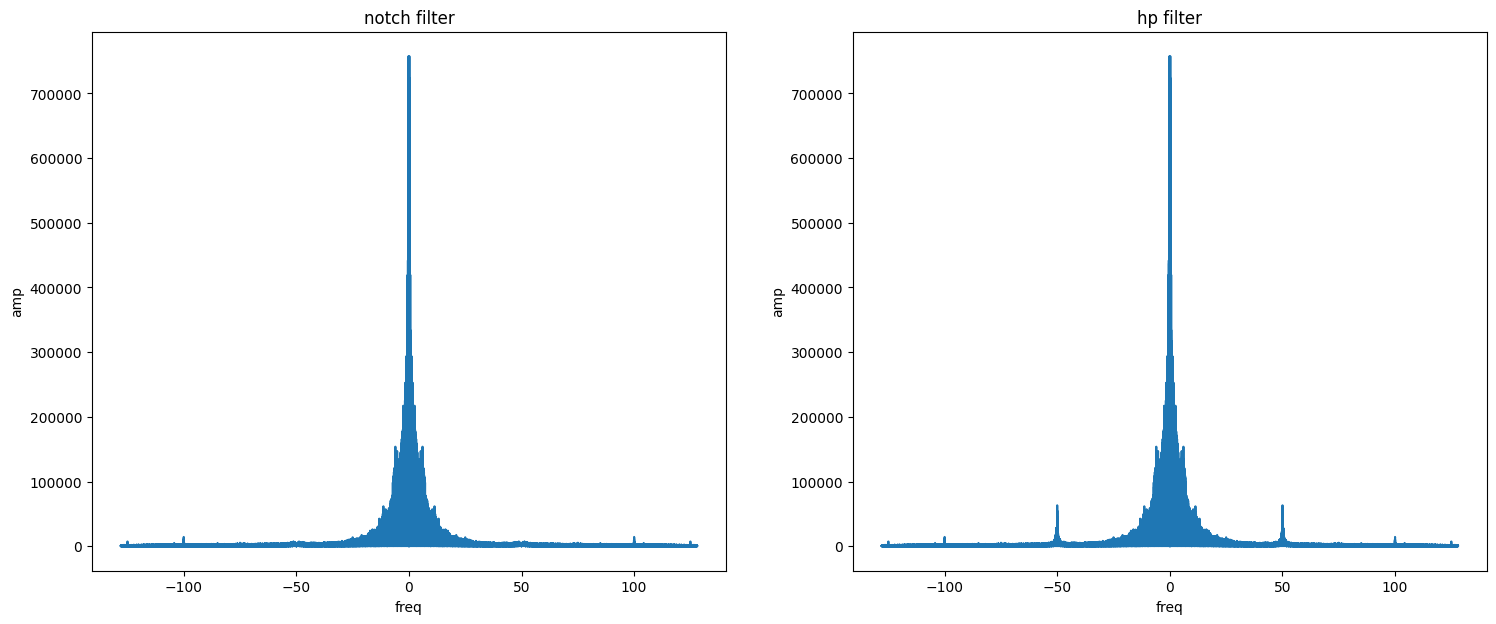

In [54]:
fig, ax = plt.subplots(1,2, figsize = (18,7))
ax[0].plot(xf, amp)
ax[0].set_title("notch filter")
ax[0].set_xlabel("freq")
ax[0].set_ylabel("amp")
ax[1].plot(xf, abs(fft(filter_hp[0])))
ax[1].set_title("hp filter")
ax[1].set_xlabel("freq")
ax[1].set_ylabel("amp")

### MinMaxScaler

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler()
scaled_signals = scaler.fit_transform(filter_notch)

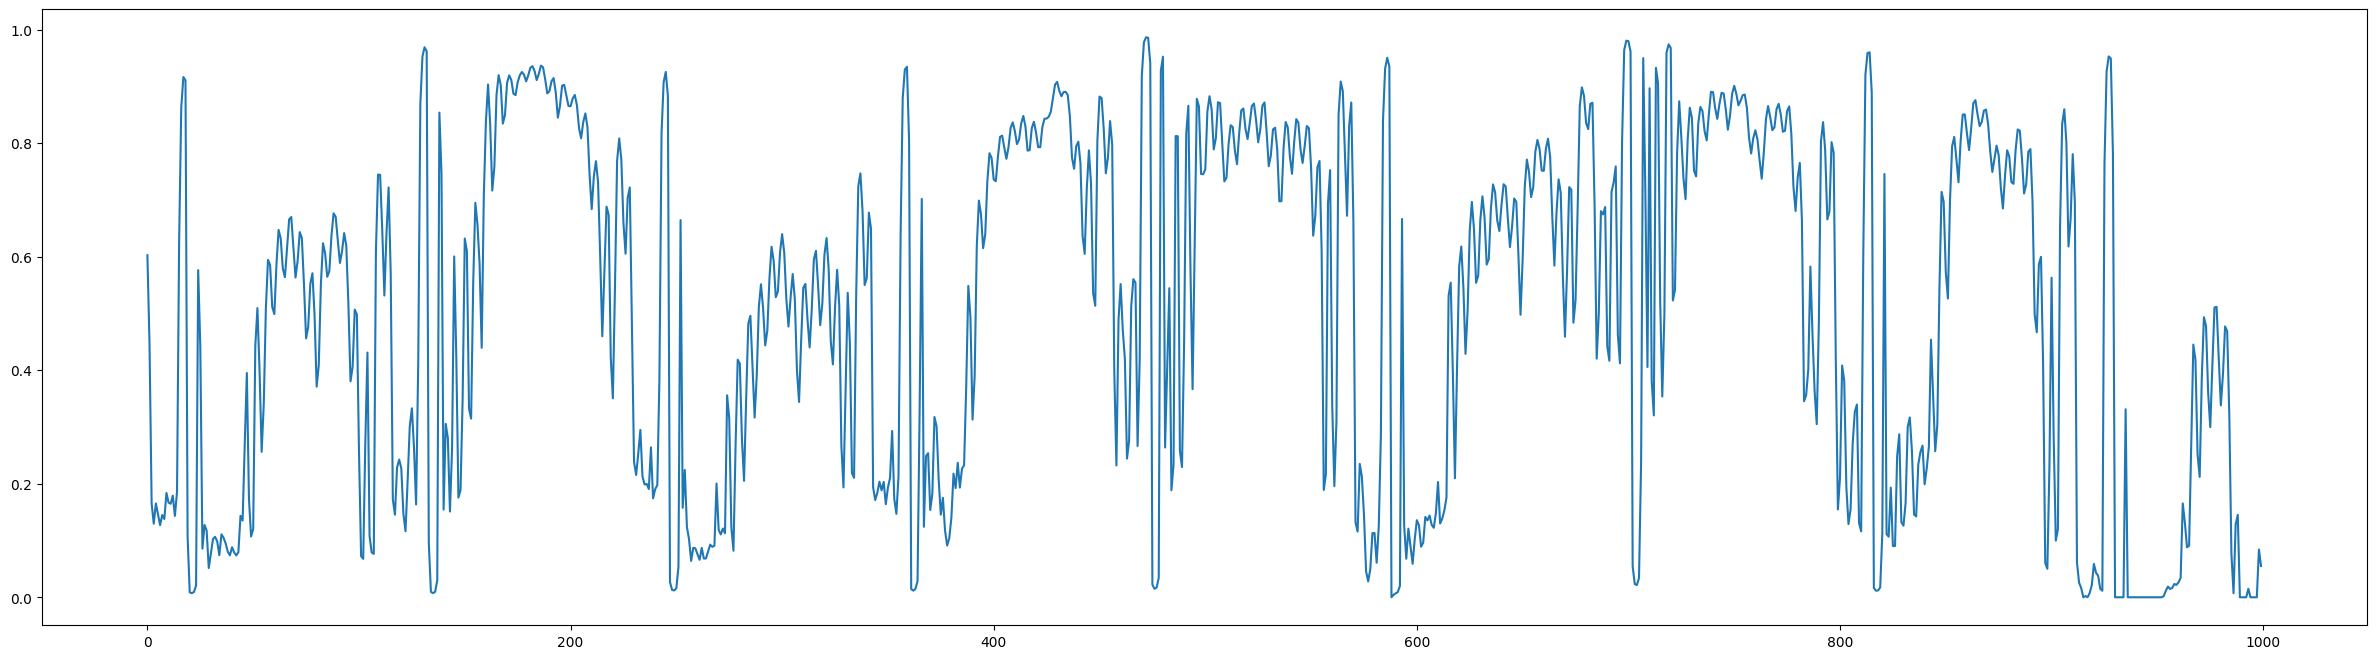

In [69]:
plt.figure(figsize=(30,8))
plt.plot(scaled_signals[8][1000:2000])

### Downsampling

In [60]:
from scipy.signal import decimate
q = 2
signals_ds = decimate(scaled_signals, q)

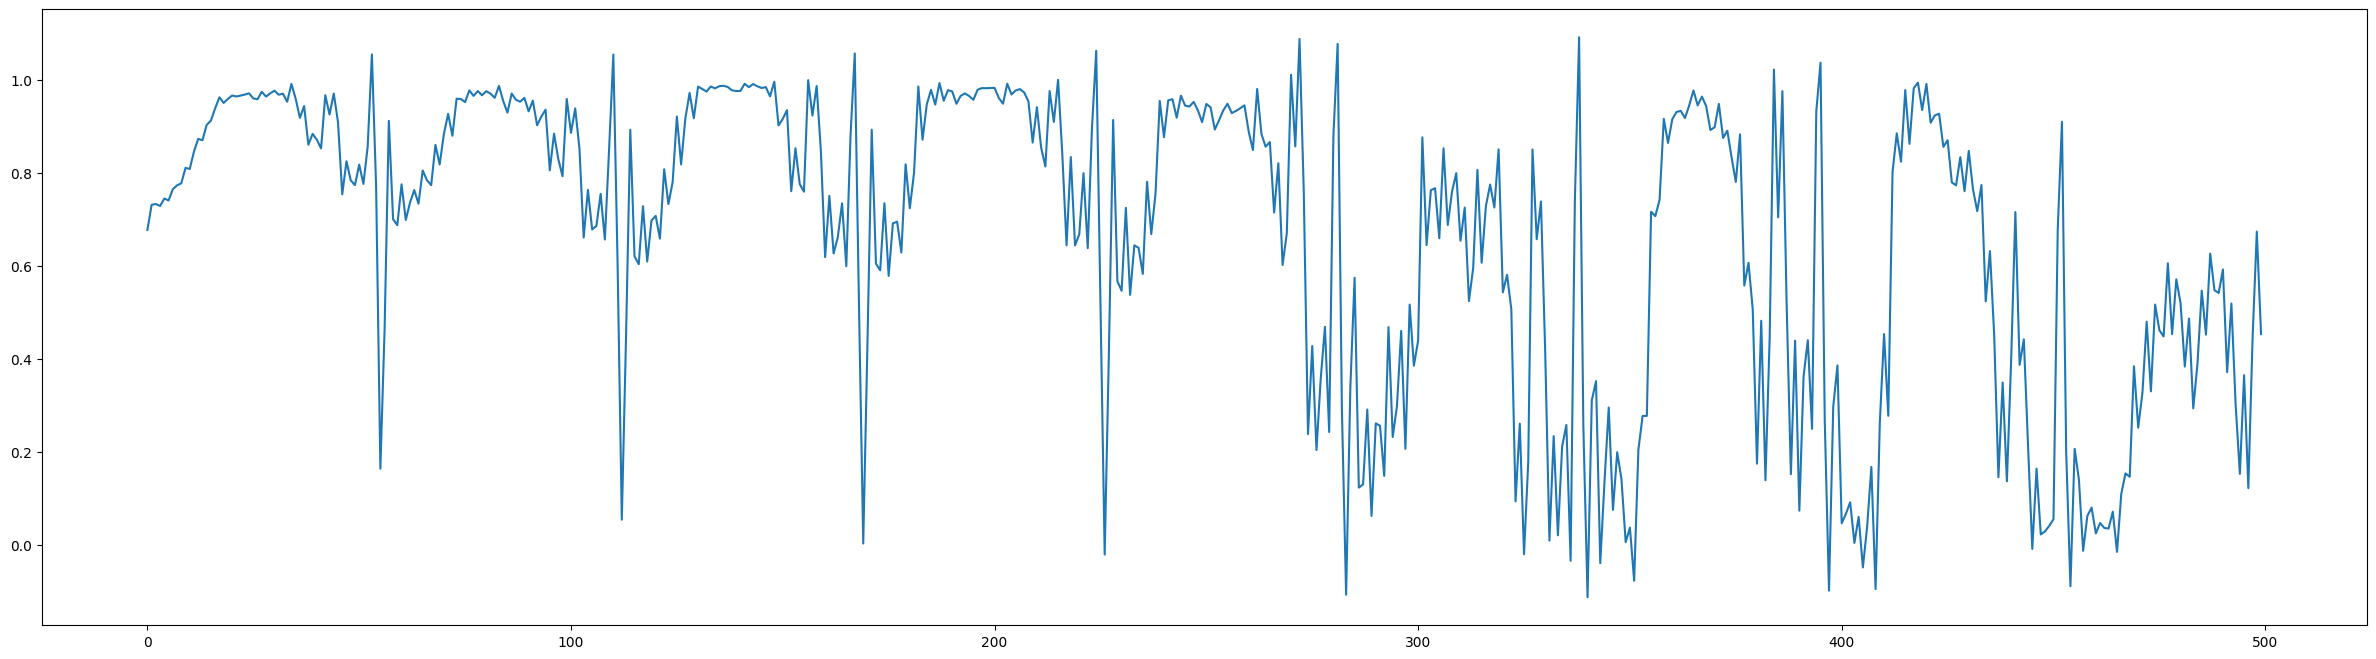

In [62]:
plt.figure(figsize=(30,8))
plt.plot(signals_ds[0][0:500])

In [64]:
signals_ds

array([[ 6.77862425e-01,  7.31879161e-01,  7.33452385e-01, ...,
         9.83003885e-01,  9.82888202e-01,  9.81661718e-01],
       [ 6.79864027e-01,  7.29240506e-01,  7.29898453e-01, ...,
         9.82540913e-01,  9.82146828e-01,  9.80948564e-01],
       [ 6.80151891e-01,  7.40555784e-01,  7.40577925e-01, ...,
         9.86627425e-01,  9.86184805e-01,  9.85316341e-01],
       ...,
       [ 6.64872627e-01,  7.44087412e-01,  7.44010798e-01, ...,
         9.77617906e-01,  9.78409649e-01,  9.77650481e-01],
       [ 9.88077088e-01,  9.89325720e-01,  9.87660575e-01, ...,
         8.87676723e-01,  8.90310938e-01,  8.93855898e-01],
       [ 1.82445954e-05, -2.65214483e-05,  2.82685377e-05, ...,
         4.29615428e-09, -4.19435316e-09,  2.98344849e-09]])

## Functions - Preprocessing

**hp filter function**

In [80]:
def highpass_filter(signals, sample_frequency, hp_frequency = 0.1):
    sos = butter(N = 3, Wn = hp_frequency, btype="highpass",fs=sample_frequency, output="sos")
    filter_hp = sosfiltfilt(sos, signals)
    return filter_hp

**notch filter function**

In [81]:
def notch_filter(signals, sample_frequency, notch_frequency = 50, quality_factor = 30):
    w0 = notch_frequency/(sample_frequency/2)
    b_notch, a_notch = iirnotch(w0, quality_factor)
    filter_notch = filtfilt(b_notch, a_notch, signals, axis = -1)
    return filter_notch

**all filters together + MinMaxScaler trends**

In [82]:
def filter_signals(signals, sample_frequency, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30):
    filter_hp = highpass_filter(signals, sample_frequency)
    filter_notch = notch_filter(signals, sample_frequency, notch_frequency, quality_factor)
    scaler = MinMaxScaler()
    final_signal = scaler.fit_transform(filter_notch)
    return final_signal

**fourier transform function**

In [147]:
def fourier_transform(signals, sample_frequency):
    if np.ndim(signals) == 1:
        y = fft(signals)
        N = len(signals)
    else:
        y = np.array([fft(signals[i]) for i in range(len(signals))])
        N = len(signals[0])
    xf = fftfreq(N, 1 / sample_frequency)
    return (xf,y)

**plot one fourier transform**

In [148]:
def plot_one_fourier(xf1, y1):
    amp = abs(y1)
    plt.plot(xf, amp)
    plt.title("power domain")
    plt.xlabel("freq")
    plt.ylabel("power")
    plt.show()

**plot all fourier trans for signals**

In [149]:
def plot_fourier(signals, sample_frequency):
    xf, y = fourier_transform(signals, sample_frequency)
    for signal in y:
        plot_one_fourier(xf, signal)

In [150]:
signals_filt = filter_signals(signals, sample_frequency=256, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30)

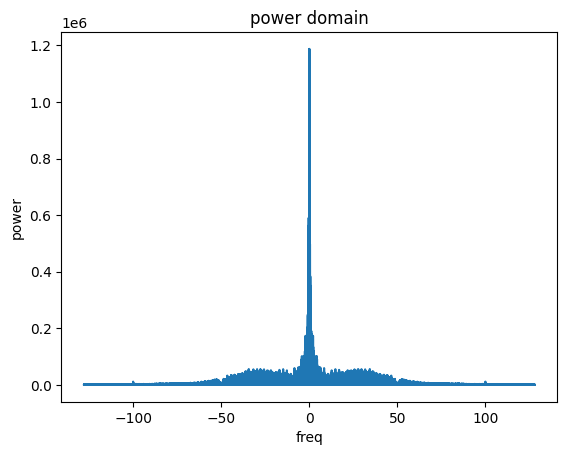

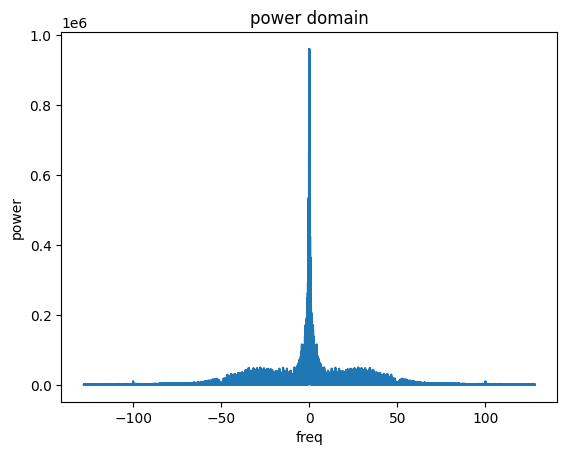

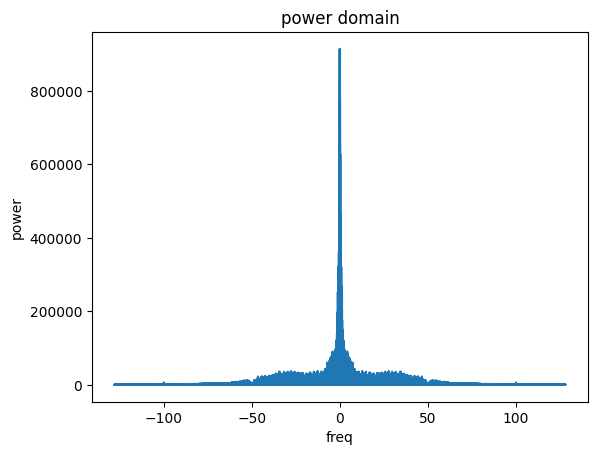

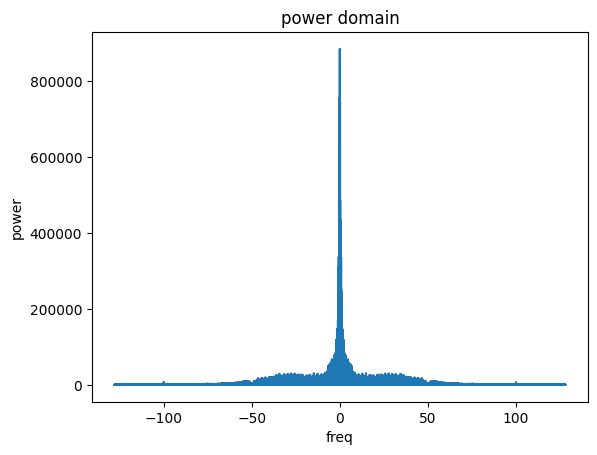

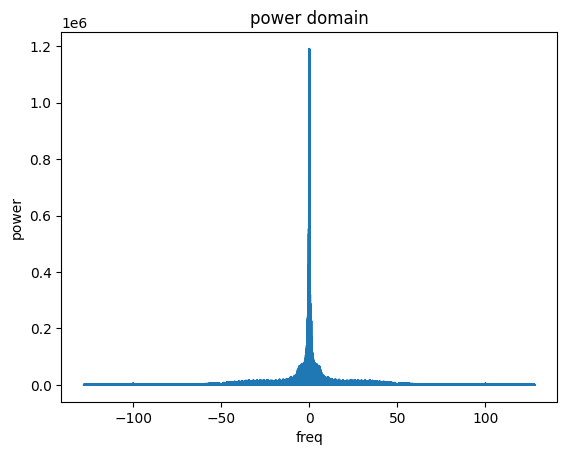

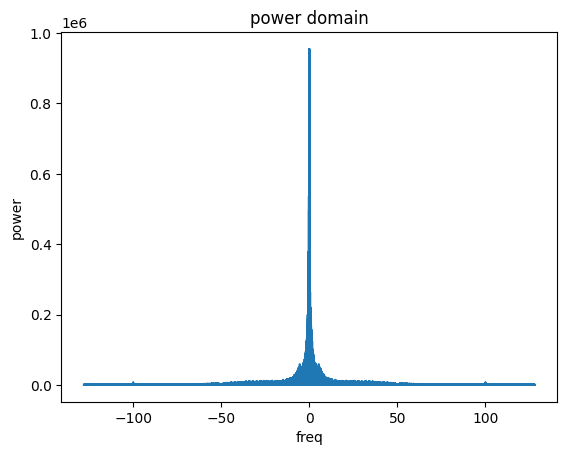

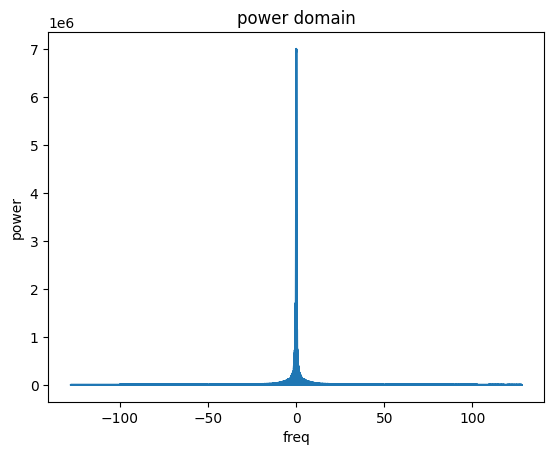

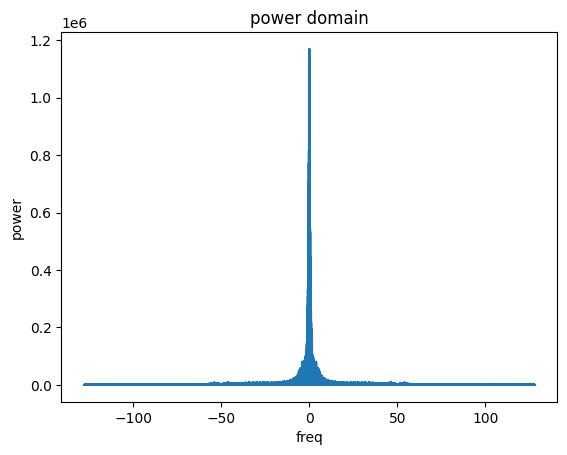

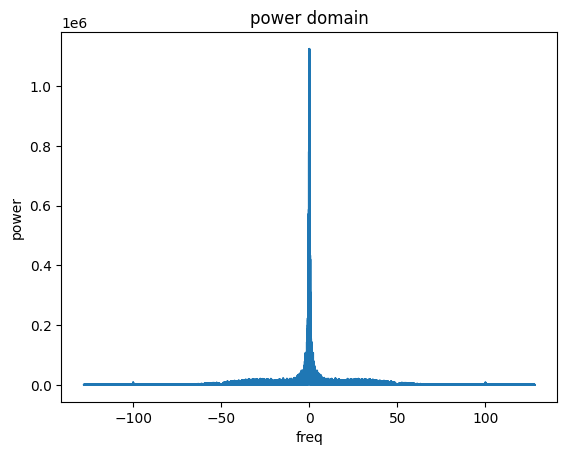

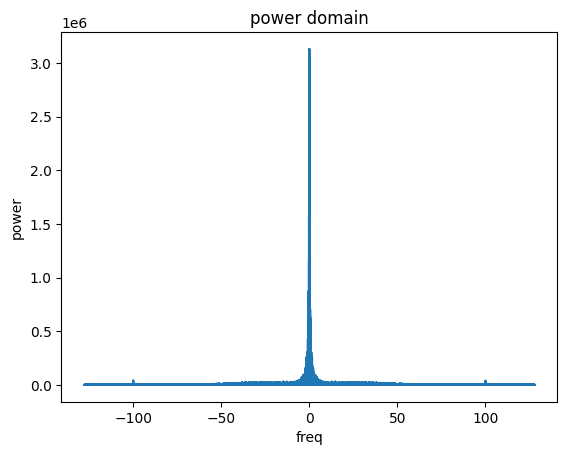

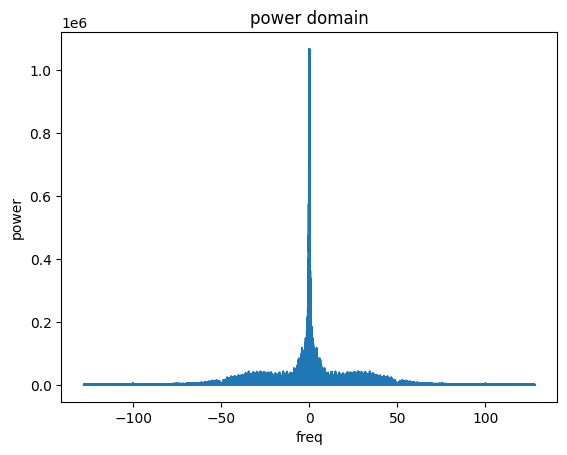

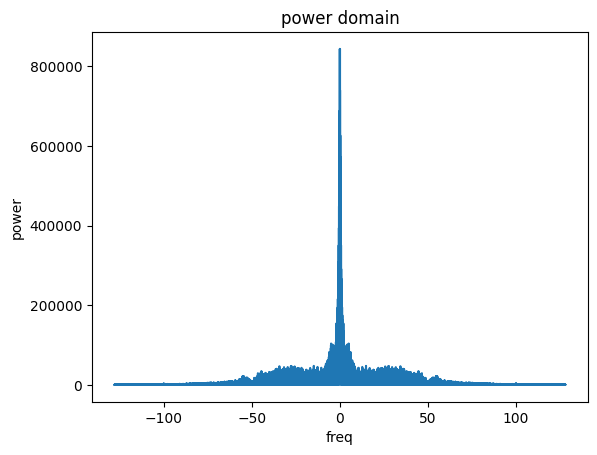

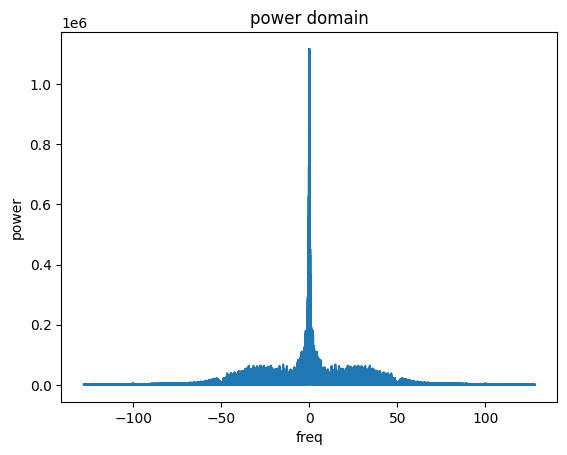

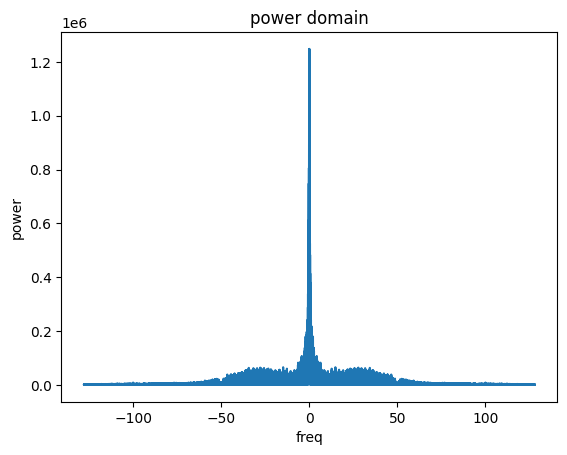

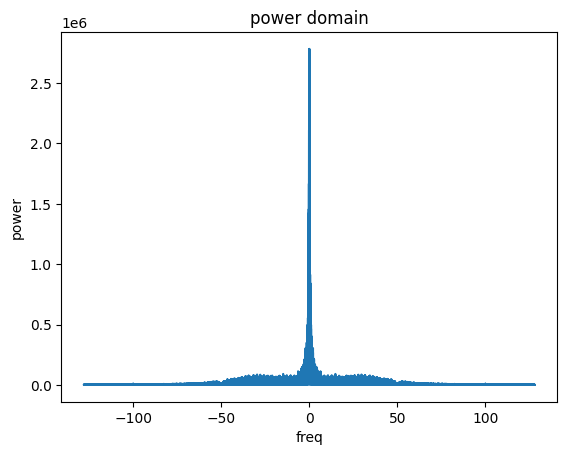

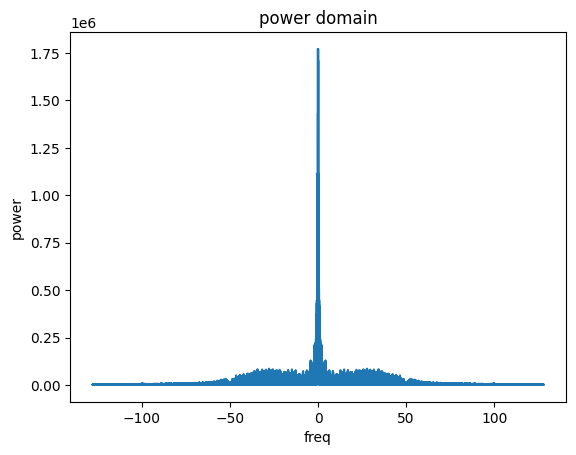

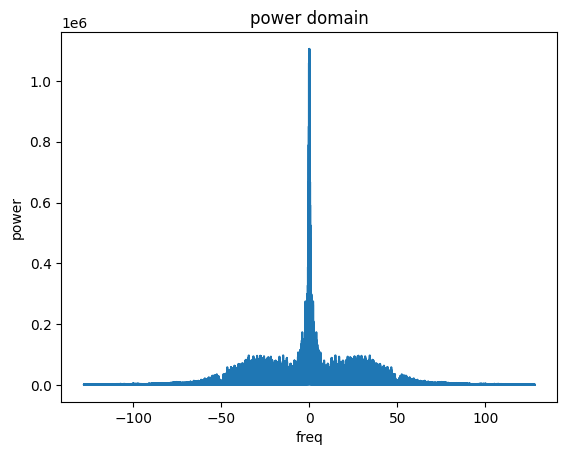

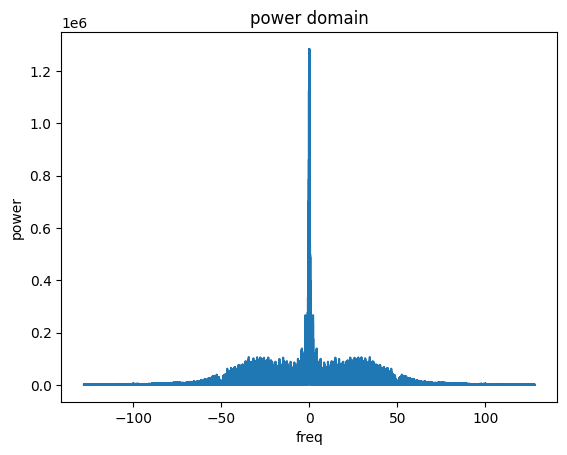

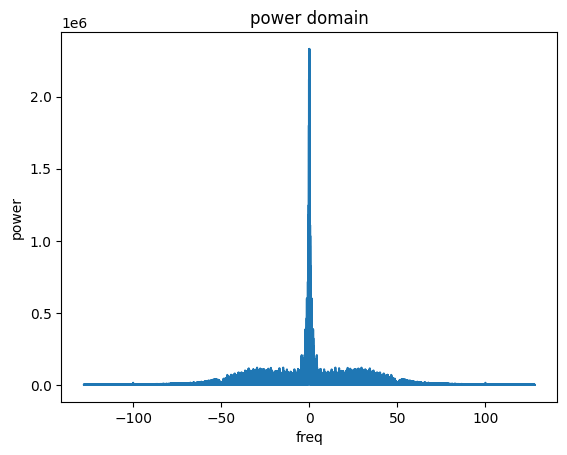

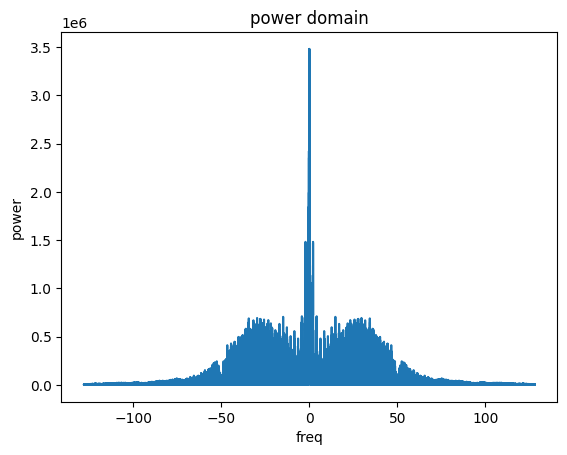

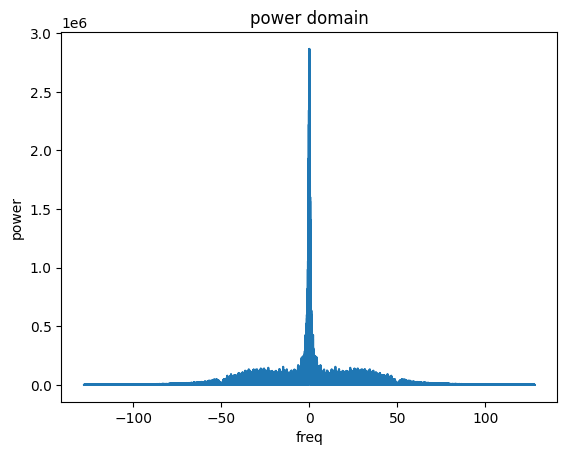

In [151]:
plot_fourier(signals_filt, 256)

**Downsampling**

In [69]:
def downsampling(signals, q=2):
    #reduce the number of samples
    ydem = decimate(signals, q)
    return ydem

In [90]:
filtered_eeg5 = filter_signals(signals, signal_headers[0]["sample_rate"], hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30)

In [91]:
filtered_eeg5

array([[0.35349406, 0.3362463 , 0.26871167, ..., 0.04068316, 0.96662543,
        0.11230736],
       [0.79357325, 0.86297437, 0.91981258, ..., 0.08036331, 1.        ,
        0.08829178],
       [1.        , 1.        , 1.        , ..., 0.02982093, 0.95923149,
        0.12131128],
       ...,
       [0.1794054 , 0.19575073, 0.24352608, ..., 0.04099057, 0.94408774,
        0.08032769],
       [0.45431842, 0.50843819, 0.52028139, ..., 1.        , 0.        ,
        1.        ],
       [0.38751772, 0.39392485, 0.42765298, ..., 0.02422145, 0.9689719 ,
        0.14485359]])

In [92]:
np.savetxt('filtered_eeg5.csv', filtered_eeg5, delimiter=',')